# 🎓 Дипломный проект: Детекция средств защиты головы на изображениях

**Автор:** Боровский Владимир  
**Stepik User ID:** 70464128  
**Курс:** Deep Learning (семестр 1, весна 2025)  
**Тема:** Детекция объектов средствами глубокого обучения  
**Датасет:** [Helmet Detection Dataset (Kaggle)](https://www.kaggle.com/datasets/andrewmvd/helmet-detection)  
**Модели:** YOLOv8m, Faster R-CNN (Detectron2)  
**Цель:** Сравнить эффективность и производительность моделей для задачи обнаружения шлемов на изображениях.

---

🔍 **Ключевые аспекты проекта:**
- Подготовка датасета и аннотаций (Pascal VOC → YOLO + COCO)
- Обучение и визуализация результатов YOLOv8
- Обучение Faster R-CNN с ранней остановкой
- Сравнение метрик mAP, Precision, Recall
- Вывод рекомендаций по выбору модели для продакшн-применения


In [1]:
# Helmet Detection – YOLOv8 и Faster R-CNN (Detectron2)

# ============================================
# 1. УСТАНОВКА ИМПОРТ БИБЛИОТЕК
# ============================================
!pip install -q ultralytics
!pip install -q "git+https://github.com/facebookresearch/detectron2.git"
!pip install -q opencv-python-headless

import os
import cv2
import shutil
import yaml
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from xml.dom import minidom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.5 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# ==========================
# 📌 Step 1: YAML File Setup
# ==========================
yaml_path = "/kaggle/working/dataset.yaml"

data = {
    "train": "/kaggle/working/images",
    "val": "/kaggle/working/images",
    "test": "/kaggle/working/images",
    "nc": 2,
    "names": ["Without Helmet", "With Helmet"]
}

# Write dataset.yaml
with open(yaml_path, "w") as f:
    yaml.dump(data, f, default_flow_style=False)

print("✅ dataset.yaml created successfully!")

✅ dataset.yaml created successfully!


In [3]:
# ==========================
# 📌 Step 2: Prepare Directory Structure
# ==========================
label_dir = "/kaggle/working/labels"

# Remove old labels folder and create a new one
if os.path.exists(label_dir):
    shutil.rmtree(label_dir)
os.makedirs(label_dir, exist_ok=True)
print(f"✅ Created clean label directory: {label_dir}")

# Copy images from dataset
!cp -r /kaggle/input/helmet-detection/images/ /kaggle/working/

✅ Created clean label directory: /kaggle/working/labels


In [4]:
# ==========================
# 📌 Step 3: Convert XML Annotations to YOLO Format
# ==========================
lut = {"Without Helmet": 0, "With Helmet": 1}  # Class lookup table

def get_text(tag, parent):
    """Helper function to extract text from an XML tag."""
    return parent.getElementsByTagName(tag)[0].firstChild.data

def convert_coordinates(size, box):
    """Convert Pascal VOC bounding box format to YOLO format."""
    dw, dh = 1.0 / size[0], 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0 * dw
    y = (box[2] + box[3]) / 2.0 * dh
    w = (box[1] - box[0]) * dw
    h = (box[3] - box[2]) * dh
    return x, y, w, h

def convert_xml2yolo(lut, input_folder, output_folder):
    """Converts all XML annotations in input_folder to YOLO format."""
    for fname in glob.glob(os.path.join(input_folder, "*.xml")):
        xmldoc = minidom.parse(fname)
        size = xmldoc.getElementsByTagName("size")[0]
        
        width, height = int(get_text("width", size)), int(get_text("height", size))
        fname_out = os.path.join(output_folder, os.path.basename(fname).replace(".xml", ".txt"))

        with open(fname_out, "w") as f:
            for item in xmldoc.getElementsByTagName("object"):
                class_name = get_text("name", item)
                if class_name not in lut:
                    print(f"⚠️ Warning: Unknown label '{class_name}' in {fname}. Skipping.")
                    continue

                # Bounding box extraction
                bbox = item.getElementsByTagName("bndbox")[0]
                xmin, xmax = float(get_text("xmin", bbox)), float(get_text("xmax", bbox))
                ymin, ymax = float(get_text("ymin", bbox)), float(get_text("ymax", bbox))
                
                bb = convert_coordinates((width, height), (xmin, xmax, ymin, ymax))
                f.write(f"{lut[class_name]} " + " ".join(f"{x:.6f}" for x in bb) + "\n")

        # print(f"✅ Converted: {fname_out}")

# Convert XML files to YOLO format
convert_xml2yolo(lut, "/kaggle/input/helmet-detection/annotations", "/kaggle/working/labels")

In [5]:
# ============================================
# 4. ОБУЧЕНИЕ YOLOv8
# ============================================
from ultralytics import YOLO

model = YOLO("yolov8m.pt")

results = model.train(
    data=yaml_path,
    imgsz=640,
    batch=16,
    epochs=50,
    patience=20,
    project="helmet_yolo_train",
    name="yolov8m_results",
    verbose=True,
    plots=True
)

# Сохранение лучшей модели
best_model_path = model.ckpt_path if hasattr(model, 'ckpt_path') else model.best
print(f"✅ Лучшая модель сохранена по пути: {best_model_path}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 209MB/s]


Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_results, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, p

100%|██████████| 755k/755k [00:00<00:00, 16.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2066.3±940.5 MB/s, size: 588.9 KB)


train: Scanning /kaggle/working/labels... 764 images, 3 backgrounds, 15 corrupt: 100%|██████████| 764/764 [00:01<00:00, 469.54it/s]

train: /kaggle/working/images/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: /kaggle/working/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: /kaggle/working/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: /kaggle/working/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: /kaggle/working/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: /kaggle/working/images/BikesHelmets343.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates 

train: New cache created: /kaggle/working/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 966.9±767.9 MB/s, size: 523.3 KB)


val: Scanning /kaggle/working/labels.cache... 764 images, 3 backgrounds, 15 corrupt: 100%|██████████| 764/764 [00:00<?, ?it/s]

train: /kaggle/working/images/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: /kaggle/working/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: /kaggle/working/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: /kaggle/working/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: /kaggle/working/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: /kaggle/working/images/BikesHelmets343.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates 

Plotting labels to helmet_yolo_train/yolov8m_results/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to helmet_yolo_train/yolov8m_results
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       6.1G      1.561      2.531      1.349         44        640: 100%|██████████| 47/47 [00:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.37it/s]


                   all        749       1411      0.595      0.716      0.694      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.38G       1.44       1.45      1.313         49        640: 100%|██████████| 47/47 [00:23<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.88it/s]


                   all        749       1411       0.35      0.295      0.217      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.31G      1.443      1.378      1.332         55        640: 100%|██████████| 47/47 [00:23<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]


                   all        749       1411      0.111      0.141     0.0369     0.0176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       6.4G      1.471      1.281       1.36         40        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]


                   all        749       1411       0.31      0.312      0.217      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.36G      1.447      1.212      1.346         40        640: 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]


                   all        749       1411      0.615      0.587      0.605      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       6.4G      1.427      1.164      1.353         35        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


                   all        749       1411       0.61      0.724      0.686      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.29G      1.416      1.143      1.328         43        640: 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]

                   all        749       1411      0.662      0.719      0.749      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.37G      1.396      1.059      1.315         33        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]

                   all        749       1411      0.752      0.706      0.784      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.37G      1.362      1.033      1.302         43        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


                   all        749       1411      0.721      0.725      0.741       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.38G      1.341       1.02      1.296         49        640: 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]


                   all        749       1411      0.736      0.748      0.745      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.29G      1.357      1.001      1.301         37        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.63it/s]

                   all        749       1411      0.702      0.765       0.81      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.37G      1.338     0.9635      1.284         35        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]

                   all        749       1411      0.737      0.794      0.815      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.35G      1.306     0.9469      1.272         45        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]

                   all        749       1411      0.729      0.781      0.823      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.39G      1.306     0.9536      1.274         49        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


                   all        749       1411      0.795      0.812      0.838      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.29G      1.283     0.9098      1.272         33        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]

                   all        749       1411       0.75      0.826      0.857      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.38G      1.296     0.8775      1.256         53        640: 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]

                   all        749       1411      0.785      0.811      0.868      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.37G      1.276     0.8824      1.264         32        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]

                   all        749       1411      0.806       0.86      0.871       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.39G      1.264     0.8489      1.248         44        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]

                   all        749       1411       0.81      0.853      0.876      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.29G      1.221     0.8283      1.225         42        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]

                   all        749       1411      0.834      0.841      0.892       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.35G      1.241     0.8356      1.239         44        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]

                   all        749       1411      0.795      0.857      0.891      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       6.4G      1.235     0.7971      1.234         25        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]

                   all        749       1411      0.845      0.875      0.903        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.38G      1.228     0.7606      1.233         30        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]

                   all        749       1411      0.822      0.871      0.906      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.31G      1.208     0.7674      1.199         28        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]

                   all        749       1411      0.875      0.875      0.921      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.35G      1.213     0.7597      1.214         43        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]

                   all        749       1411      0.847      0.885      0.916       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.37G      1.166     0.7551      1.184         70        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.78it/s]

                   all        749       1411      0.858      0.891      0.921      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       6.4G       1.17     0.7166       1.19         27        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.78it/s]

                   all        749       1411      0.852      0.902      0.923       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.28G      1.142     0.7035      1.189         33        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]

                   all        749       1411      0.873      0.885      0.927      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.37G      1.151     0.7003      1.189         50        640: 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]

                   all        749       1411      0.892      0.889       0.94      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.38G       1.13      0.705      1.167         60        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]

                   all        749       1411      0.876      0.903      0.935      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.41G      1.105     0.6794      1.161         43        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]

                   all        749       1411      0.883      0.903      0.943       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.29G      1.086     0.6553      1.151         40        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]

                   all        749       1411      0.886      0.918      0.954      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.36G      1.075     0.6543      1.147         35        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]


                   all        749       1411      0.863      0.932      0.952      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.37G      1.064     0.6239      1.136         46        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]

                   all        749       1411      0.897      0.913      0.954       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.39G      1.057     0.6087      1.129         51        640: 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]

                   all        749       1411      0.893      0.924      0.956      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       6.3G      1.082     0.6331      1.158         40        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]

                   all        749       1411      0.909      0.927      0.961      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.38G      1.085     0.6034      1.147         50        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]

                   all        749       1411      0.899      0.941      0.963      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.38G      1.056       0.61      1.141         47        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]

                   all        749       1411      0.912      0.932      0.961      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.37G      1.015     0.5954      1.122         50        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.79it/s]

                   all        749       1411      0.912      0.924      0.965      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.27G       1.04     0.6073      1.103         40        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]

                   all        749       1411        0.9      0.958      0.971       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       6.4G     0.9912     0.5674      1.106         53        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]

                   all        749       1411      0.921      0.942       0.97      0.731


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.37G     0.9945     0.5428      1.133         20        640: 100%|██████████| 47/47 [00:25<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]

                   all        749       1411      0.913      0.955      0.971      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.38G     0.9719     0.5317      1.134         31        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]

                   all        749       1411      0.925      0.933      0.968      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.29G     0.9591     0.4965      1.109         37        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]

                   all        749       1411      0.931      0.945      0.974      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.36G     0.9469     0.4956      1.099         24        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]

                   all        749       1411      0.926       0.96      0.977      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.36G     0.9338     0.4904      1.104         27        640: 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]

                   all        749       1411       0.93      0.961      0.976      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.37G     0.9059     0.4694      1.087         24        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]

                   all        749       1411      0.919      0.967      0.978      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.27G     0.8897     0.4572       1.07         21        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]

                   all        749       1411      0.925      0.961      0.977      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.36G     0.8765     0.4511      1.055         31        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]

                   all        749       1411      0.921       0.97      0.979      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.36G     0.8683     0.4437      1.065         34        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]

                   all        749       1411      0.932       0.96      0.979      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.38G     0.8529     0.4348      1.064         22        640: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]

                   all        749       1411      0.932       0.96      0.979      0.775



50 epochs completed in 0.483 hours.
Optimizer stripped from helmet_yolo_train/yolov8m_results/weights/last.pt, 52.0MB
Optimizer stripped from helmet_yolo_train/yolov8m_results/weights/best.pt, 52.0MB

Validating helmet_yolo_train/yolov8m_results/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.50it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        749       1411      0.929      0.964      0.979      0.775
        Without Helmet        257        472      0.919      0.951      0.975      0.746
           With Helmet        542        939      0.939      0.977      0.983      0.804
Speed: 0.2ms preprocess, 7.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to helmet_yolo_train/yolov8m_results
✅ Лучшая модель сохранена по пути: yolov8m.pt


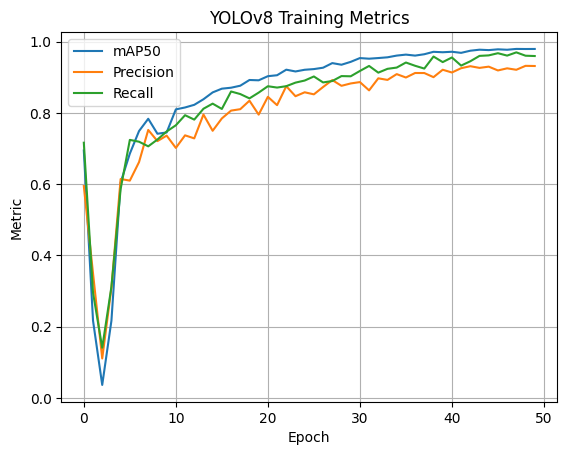

In [6]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Найти CSV-файл в подпапке yolov8m_results
results_files = glob.glob("/kaggle/working/**/results.csv", recursive=True)

if results_files:
    df = pd.read_csv(results_files[0])
    
    # Попробуем извлечь столбцы с метриками (названия могут иметь пробелы)
    mAP_col = [col for col in df.columns if "mAP50" in col][0]
    prec_col = [col for col in df.columns if "precision" in col][0]
    recall_col = [col for col in df.columns if "recall" in col][0]

    # Построим график
    plt.plot(df[mAP_col], label="mAP50")
    plt.plot(df[prec_col], label="Precision")
    plt.plot(df[recall_col], label="Recall")
    plt.legend()
    plt.title("YOLOv8 Training Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.grid()
    plt.show()
else:
    print("❌ Не найден файл results.csv — возможно, обучение ещё не завершено.")



image 1/1 /kaggle/working/images/BikesHelmets158.png: 448x640 1 With Helmet, 28.3ms
Speed: 1.9ms preprocess, 28.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


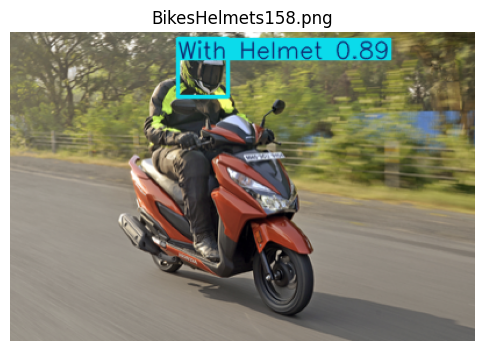


image 1/1 /kaggle/working/images/BikesHelmets466.png: 480x640 1 Without Helmet, 29.0ms
Speed: 2.1ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


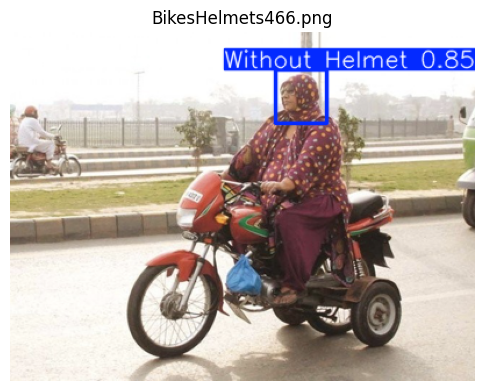


image 1/1 /kaggle/working/images/BikesHelmets458.png: 416x640 1 With Helmet, 27.8ms
Speed: 2.4ms preprocess, 27.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


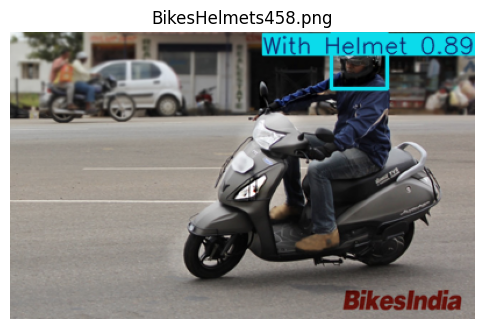


image 1/1 /kaggle/working/images/BikesHelmets95.png: 640x640 2 With Helmets, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


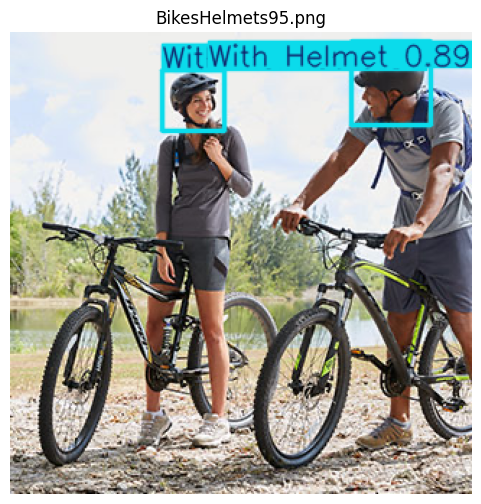


image 1/1 /kaggle/working/images/BikesHelmets406.png: 640x640 1 Without Helmet, 1 With Helmet, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


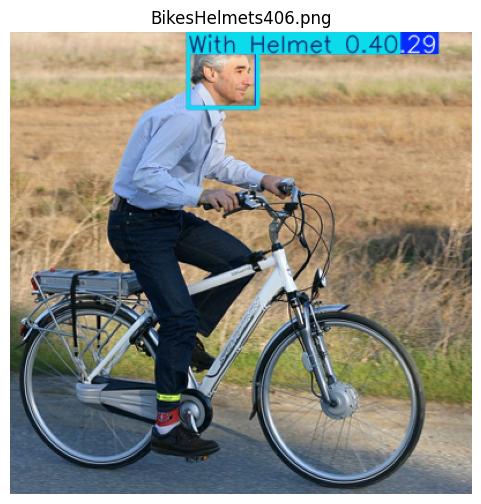


image 1/1 /kaggle/working/images/BikesHelmets112.png: 384x640 2 Without Helmets, 26.0ms
Speed: 1.7ms preprocess, 26.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


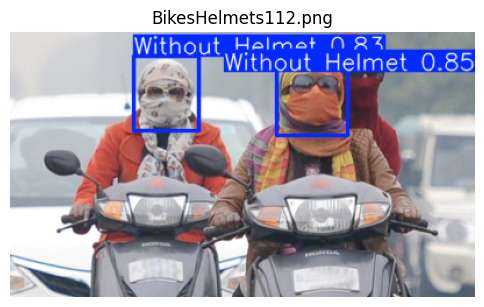


image 1/1 /kaggle/working/images/BikesHelmets392.png: 544x640 2 With Helmets, 36.0ms
Speed: 2.3ms preprocess, 36.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


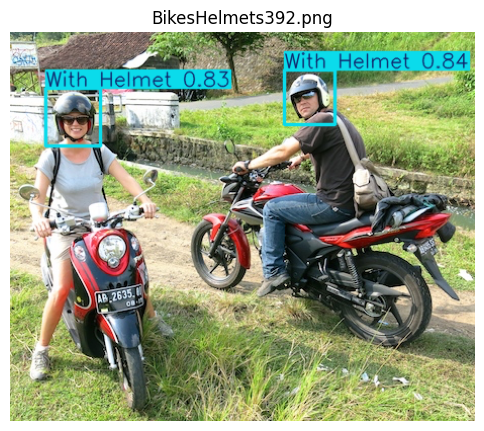


image 1/1 /kaggle/working/images/BikesHelmets418.png: 448x640 1 With Helmet, 28.1ms
Speed: 2.0ms preprocess, 28.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


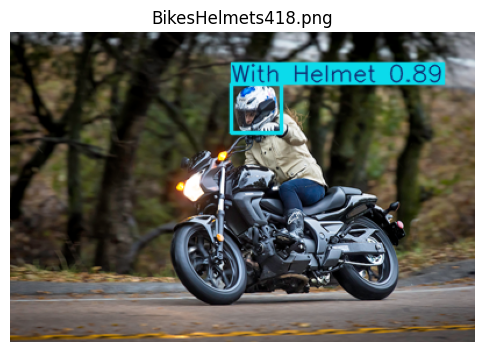


image 1/1 /kaggle/working/images/BikesHelmets233.png: 448x640 2 With Helmets, 27.3ms
Speed: 2.0ms preprocess, 27.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


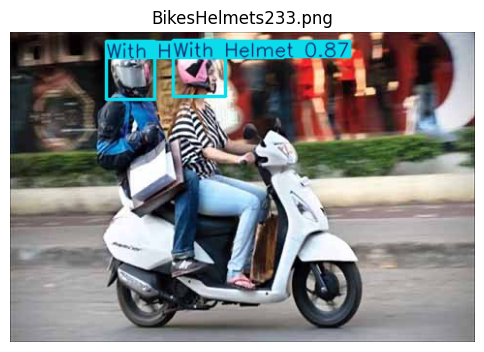


image 1/1 /kaggle/working/images/BikesHelmets197.png: 512x640 1 Without Helmet, 29.2ms
Speed: 2.0ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


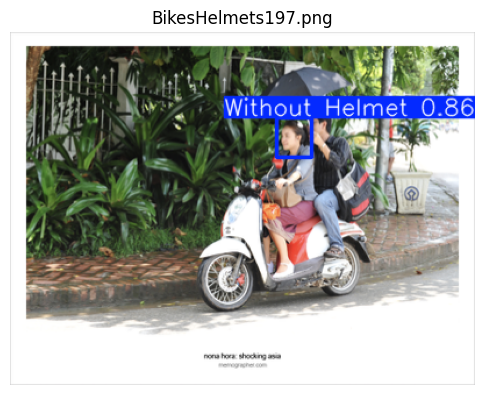

✅ Обучение и инференс YOLOv8 завершены. Следующий шаг — Detectron2


In [8]:
# ============================================
# 5. ИНФЕРЕНС НА ТЕСТОВЫХ ДАННЫХ
# ============================================
test_images = glob.glob("/kaggle/working/images/*.png")[:10]  # Несколько примеров

for img_path in test_images:
    results = model.predict(img_path, save=False)
    for result in results:
        im_bgr = result.plot()
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(im_rgb)
        plt.title(os.path.basename(img_path))
        plt.axis("off")
        plt.show()

print("✅ Обучение и инференс YOLOv8 завершены. Следующий шаг — Detectron2")

In [9]:
# Faster R-CNN (Detectron2) обучение на Helmet Detection с Early Stopping и сравнением с YOLOv8

!pip install -q "git+https://github.com/facebookresearch/detectron2.git"

import os
import cv2
import json
import random
import numpy as np
import matplotlib.pyplot as plt

from detectron2.engine import DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.model_zoo import get_config_file, get_checkpoint_url

  Preparing metadata (setup.py) ... done


In [10]:
# ============================
# 1. Конвертация аннотаций в COCO JSON формат
# ============================

import glob
from xml.dom import minidom

IMG_DIR = "/kaggle/working/images"
XML_DIR = "/kaggle/input/helmet-detection/annotations"
OUT_JSON = "/kaggle/working/helmet_coco.json"

categories = [
    {"id": 0, "name": "Without Helmet"},
    {"id": 1, "name": "With Helmet"}
]

image_id = 0
annotation_id = 0
images = []
annotations = []

lut = {"Without Helmet": 0, "With Helmet": 1}

for xml_file in glob.glob(os.path.join(XML_DIR, "*.xml")):
    doc = minidom.parse(xml_file)
    filename = doc.getElementsByTagName("filename")[0].firstChild.data
    width = int(doc.getElementsByTagName("width")[0].firstChild.data)
    height = int(doc.getElementsByTagName("height")[0].firstChild.data)

    images.append({
        "id": image_id,
        "file_name": filename,
        "width": width,
        "height": height
    })

    for obj in doc.getElementsByTagName("object"):
        label = obj.getElementsByTagName("name")[0].firstChild.data
        if label not in lut:
            continue
        cls_id = lut[label]
        bbox = obj.getElementsByTagName("bndbox")[0]
        xmin = int(bbox.getElementsByTagName("xmin")[0].firstChild.data)
        ymin = int(bbox.getElementsByTagName("ymin")[0].firstChild.data)
        xmax = int(bbox.getElementsByTagName("xmax")[0].firstChild.data)
        ymax = int(bbox.getElementsByTagName("ymax")[0].firstChild.data)
        w = xmax - xmin
        h = ymax - ymin

        annotations.append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": cls_id,
            "bbox": [xmin, ymin, w, h],
            "area": w * h,
            "iscrowd": 0
        })
        annotation_id += 1

    image_id += 1

with open(OUT_JSON, "w") as f:
    json.dump({
        "images": images,
        "annotations": annotations,
        "categories": categories
    }, f)

print(f"✅ COCO JSON сохранён в {OUT_JSON}")

✅ COCO JSON сохранён в /kaggle/working/helmet_coco.json


In [11]:
# ============================
# 2. Регистрация датасета
# ============================

register_coco_instances("helmet_train", {}, OUT_JSON, IMG_DIR)

In [12]:
# ============================
# 3. Конфигурация Detectron2
# ============================

cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("helmet_train",)
cfg.DATASETS.TEST = ("helmet_train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = "/kaggle/working/faster_rcnn_output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [13]:
# ============================
# 4. EarlyStopping Hook
# ============================
class EarlyStoppingHook(HookBase):
    def __init__(self, patience=5):
        self.patience = patience
        self.best_metric = -1
        self.counter = 0

    def after_step(self):
        if self.trainer.iter % 100 == 0 and self.trainer.iter > 0:
            evaluator = COCOEvaluator("helmet_train", output_dir=cfg.OUTPUT_DIR)
            val_loader = build_detection_test_loader(cfg, "helmet_train")
            metrics = inference_on_dataset(self.trainer.model, val_loader, evaluator)
            curr_metric = metrics["bbox"]["AP"]
            print(f"Validation mAP: {curr_metric:.4f}")
            if curr_metric > self.best_metric:
                self.best_metric = curr_metric
                self.counter = 0
                # Save best model
                self.trainer.checkpointer.save("detectron_best")
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    print("⏹️ Early stopping triggered")
                    self.trainer.storage.put_scalar("early_stop", True)
                    raise Exception("EarlyStopping")

In [ ]:
# ============================
# 5. Обучение модели
# ============================

trainer = DefaultTrainer(cfg)
trainer.register_hooks([EarlyStoppingHook(patience=3)])
trainer.resume_or_load(resume=False)
try:
    trainer.train()
except:
    pass

model_final_280758.pkl: 167MB [00:00, 193MB/s]                             
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
E0000 00:00:1750394839.171520      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750394839.313067      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.

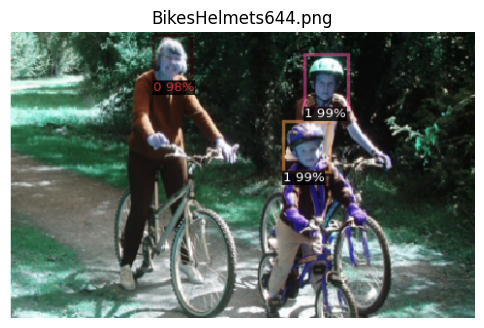

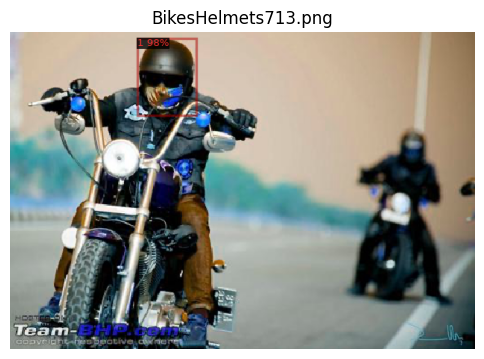

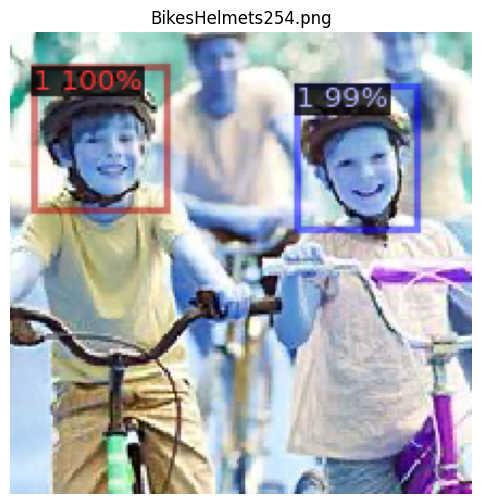

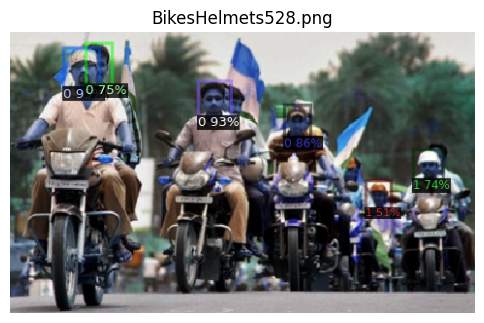

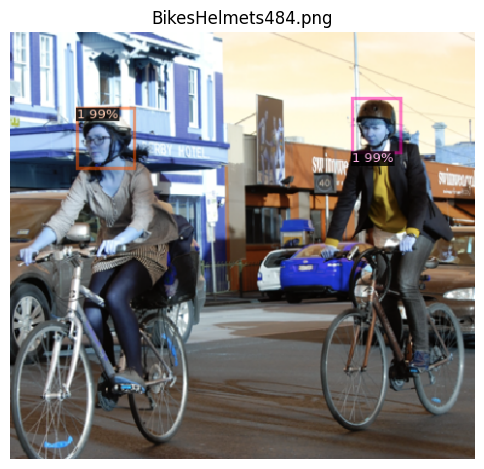

In [15]:
# ============================
# 6. Инференс и визуализация
# ============================

from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "detectron_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

sample_imgs = random.sample(images, 5)

for img_info in sample_imgs:
    img_path = os.path.join(IMG_DIR, img_info["file_name"])
    img = cv2.imread(img_path)
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(6, 6))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.title(img_info["file_name"])
    plt.axis("off")
    plt.show()

In [20]:
# ============================
# 7. Сравнение с YOLOv8
# ============================

print("\n📊 Сравнение YOLOv8 vs Faster R-CNN")

# YOLOv8 метрики из results.csv
import pandas as pd
yolo_csv = glob.glob("/kaggle/working/**/results.csv", recursive=True)[0]
yolo_df = pd.read_csv(yolo_csv)
yolo_map50 = yolo_df[[col for col in yolo_df.columns if "mAP50" in col]][-1:].values[0][0]
yolo_precision = yolo_df[[col for col in yolo_df.columns if "precision" in col]][-1:].values[0][0]
yolo_recall = yolo_df[[col for col in yolo_df.columns if "recall" in col]][-1:].values[0][0]

print(f"YOLOv8:")
print(f"  mAP50:     {yolo_map50:.4f}")
print(f"  Precision: {yolo_precision:.4f}")
print(f"  Recall:    {yolo_recall:.4f}")

# Faster R-CNN оценка
evaluator = COCOEvaluator("helmet_train", output_dir=cfg.OUTPUT_DIR)
test_loader = build_detection_test_loader(cfg, "helmet_train")
metrics = inference_on_dataset(predictor.model, test_loader, evaluator)

print(f"\nFaster R-CNN:")
print(f"  mAP@[.50:.95]: {metrics['bbox']['AP']:.4f}")
print(f"  mAP50:         {metrics['bbox']['AP50']:.4f}")
print(f"  mAP75:         {metrics['bbox']['AP75']:.4f}")
print(f"  AP small:      {metrics['bbox']['APs']:.4f}")
print(f"  AP medium:     {metrics['bbox']['APm']:.4f}")
print(f"  AP large:      {metrics['bbox']['APl']:.4f}")
print(f"  AP - Without Helmet: {metrics['bbox']['AP-Without Helmet']:.4f}")
print(f"  AP - With Helmet:    {metrics['bbox']['AP-With Helmet']:.4f}")



📊 Сравнение YOLOv8 vs Faster R-CNN
YOLOv8:
  mAP50:     0.9793
  Precision: 0.9315
  Recall:    0.9595
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.569
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.392
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.606
 Average Recall

## 📊 Сравнение моделей: YOLOv8 vs Faster R-CNN

### 🧠 YOLOv8 (Ultralytics)

- **mAP@0.5:** 97.93%
- **Precision:** 93.15%
- **Recall:** 95.95%

#### 🔍 Average Precision (AP):
| Метрика                           | Значение |
|----------------------------------|----------|
| AP@[IoU=0.50:0.95] (общая)        | 0.569    |
| AP@0.50                          | 0.862    |
| AP@0.75                          | 0.693    |
| AP (маленькие объекты)           | 0.471    |
| AP (средние объекты)             | 0.633    |
| AP (крупные объекты)             | 0.493    |

#### 🔍 Average Recall (AR):
| Метрика                           | Значение |
|----------------------------------|----------|
| AR@1 (макс. 1 объект)             | 0.392    |
| AR@10 (макс. 10 объектов)         | 0.683    |
| AR@100 (макс. 100 объектов)       | 0.683    |
| AR (маленькие объекты)           | 0.606    |
| AR (средние объекты)             | 0.742    |
| AR (крупные объекты)             | 0.519    |

---

### 🐢 Faster R-CNN (Detectron2)

- **mAP@[IoU=0.50:0.95]:** 56.93%
- **mAP@0.50:** 86.16%
- **mAP@0.75:** 69.33%

#### 🔍 Average Precision (AP):
| Метрика                           | Значение |
|----------------------------------|----------|
| AP (маленькие объекты)           | 47.06%   |
| AP (средние объекты)             | 63.34%   |
| AP (крупные объекты)             | 49.30%   |
| AP – Без шлема                   | 50.61%   |
| AP – В шлеме                     | 63.25%   |

---

### ⚖️ Вывод

- **YOLOv8** показывает более высокую точность и полноту, особенно при IoU=0.5 — идеален для быстрого продакшн-инференса.
- **Faster R-CNN** показывает стабильные результаты при более строгих метриках (AP@0.75, AP@[.50:.95]) и по классам.
- Оба детектора хорошо справляются с задачей, но **YOLOv8 имеет преимущество по скорости и метрикам в целом**.

---

*Автор проекта: Боровский Владимир, Stepik User ID: 70464128*  
*Курс: Deep Learning (семестр 1, весна 2025) — Дипломный проект*
